<a href="https://colab.research.google.com/github/KnzMcn/Machine-Learning/blob/main/Macan_ML_M5L2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**INSTRUCTIONS:** Evaluate your models using the metrics we covered in this Lesson.

# Import the libraries

In [ ]:
#if image_dataset_loader is not available uncomment the line below
!pip install image-dataset-loader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import image_dataset_loader

import keras
from keras.models import Model, Sequential
from keras.optimizers import RMSprop
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization

from google.colab import drive
import zipfile
import os
from PIL import Image

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Import the dataset

In [ ]:
#the commented code below only works on local source, change it as needed
#(X_train, y_train), (X_test, y_test), (X_val, y_val) = image_dataset_loader.load("C:/Users/TOSHIBA_2/Documents/College/3rd - First Sem/Machine Learning/Codes/Learning Evidence/Fold1", ['Train', 'Test', 'Val'])

In [ ]:
#using Gdrive to import the dataset into Google Colab
#will ask for authorization
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#if /tmp has contents or repeating Fold1 contents, delete using the line below
#%rm -rf /tmp/Fold1

In [ ]:
#unzip the desired folder and extract the contents into the tmp folder
#edit the first one depending on where the zipfile is stored in your Gdrive
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/3rd year/Machine Learning/Learning Evidence/Alzheimers.zip', 'r') #Opens the file in read mode
zip_ref.extractall('/tmp')
zip_ref.close()

In [ ]:
#resize the image for faster processing
#no need to edit the next line, it will just overwrite the original data with the resized data
#but if you're working locally, change it according to the path of the dataset
main_directory = '/tmp/Alzheimers/'

for subdir, dirs, files in os.walk(main_directory):
  for file in files:
    filepath = os.path.join(subdir, file)

    if filepath.endswith('.jpg'):
      im = Image.open(filepath)
      imResize = im.resize((75, 75), Image.ANTIALIAS)
      imResize.save(filepath, 'JPEG', quality=90)

In [ ]:
#import the images and divide them according to their folders
#label_test/train/val is for original labels that is without one hot encoding
(train_set, label_train_set), (X_test, label_test) = image_dataset_loader.load('/tmp/Alzheimers', ['train', 'test'])

In [ ]:
#split the training set into train and validation sets
X_train, X_val, label_train, label_val = train_test_split(train_set, label_train_set, random_state = 0, test_size = 0.20)

In [ ]:
#print the shape of each set
print("X_train shape: {}\nlabel_train shape: {}".format(X_train.shape, label_train.shape))
print("\nX_test shape: {}\nlabel_test shape: {}".format(X_test.shape, label_test.shape))
print("\nX_val shape: {}\nlabel_val shape: {}".format(X_val.shape, label_val.shape))

X_train shape: (4096, 75, 75)
label_train shape: (4096,)

X_test shape: (1279, 75, 75)
label_test shape: (1279,)

X_val shape: (1025, 75, 75)
label_val shape: (1025,)


In [ ]:
#create dictionary of target classes
label_dict = {
    0: 'Mild Demented',
    1: 'Moderate Demented',
    2: 'Non Demented',
    3: 'Very Mild Demented'
}

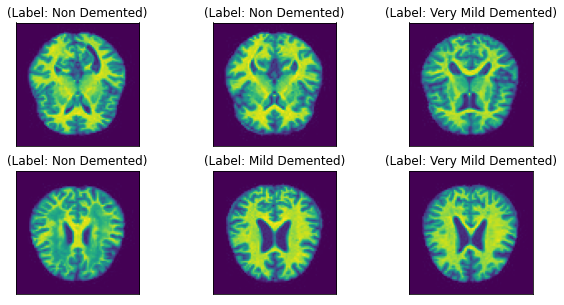

In [ ]:
#display images
plt.figure(figsize = [10, 5])

n = 3 #how many images to display
for i in range(n):
    #training images
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_train[i].reshape(75, 75))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    curr_lbl = label_train[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) +")")

    #testing images
    ax = plt.subplot(2, n, i+1+n)
    plt.imshow(X_test[i].reshape(75, 75))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    curr_lbl = label_test[i]
    plt.title("(Label: " + str(label_dict[curr_lbl]) +")")
plt.show()

In [ ]:
#print the labels for each set
print("Labels for label_train: {}".format(label_train[:5]))
print("Labels for label_test: {}".format(label_test[:5]))
print("Labels for label_val: {}".format(label_val[:5]))

Labels for label_train: [2 2 3 2 1]
Labels for label_test: [2 0 3 2 2]
Labels for label_val: [3 2 0 0 3]


# Preprocessing

In [ ]:
#cleaning and reshaping the data
X_train = X_train.astype('float32') / 255
X_train = np.reshape(X_train, (len(X_train), 75, 75, 1))
X_test = X_test.astype('float32') / 255
X_test = np.reshape(X_test, (len(X_test), 75, 75, 1))
X_val = X_val.astype('float32') / 255
X_val = np.reshape(X_val, (len(X_val), 75, 75, 1))

In [ ]:
#convert labels into one-hot encoding vectors
encoded_train = to_categorical(label_train)
encoded_test = to_categorical(label_test)
encoded_val = to_categorical(label_val)

#display the changes by the one-hot encoding
print('Original label:', label_train[0])
print('After conversion to one-hot:', encoded_train[0])

Original label: 2
After conversion to one-hot: [0. 0. 1. 0.]


In [ ]:
#print the shape of each set
print("X_train shape: {}\nencoded_train shape: {}".format(X_train.shape, encoded_train.shape))
print("\nX_test shape: {}\nencoded_test shape: {}".format(X_test.shape, encoded_test.shape))
print("\nX_val shape: {}\nencoded_val shape: {}".format(X_val.shape, encoded_val.shape))

X_train shape: (4096, 75, 75, 1)
encoded_train shape: (4096, 4)

X_test shape: (1279, 75, 75, 1)
encoded_test shape: (1279, 4)

X_val shape: (1025, 75, 75, 1)
encoded_val shape: (1025, 4)


# Convolutional Autoencoder

In [ ]:
model = Sequential()

model.add(Conv2D(32, (5,5), activation='relu', input_shape=(75, 75,1)))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (5, 5), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Flatten())
model.add(Dense(4, activation='softmax'))


In [ ]:
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 71, 71, 32)        832       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 35, 35, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 31, 31, 64)        51264     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 15, 15, 64)       0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 14400)             0         
                                                                 
 dense_6 (Dense)             (None, 4)                

# Train the model

In [ ]:
model_train = model.fit(X_train, label_train, 
                        batch_size = 256,
                        epochs = 10,
                        verbose = 1,
                        validation_data = (X_val, label_val))

Epoch 1/10
16/16 [==============================] - 36s 2s/step - loss: 1.0723 - accuracy: 0.4714 - val_loss: 1.0044 - val_accuracy: 0.5151
Epoch 2/10
16/16 [==============================] - 34s 2s/step - loss: 1.0093 - accuracy: 0.5088 - val_loss: 0.9779 - val_accuracy: 0.5561
Epoch 3/10
16/16 [==============================] - 35s 2s/step - loss: 0.9536 - accuracy: 0.5442 - val_loss: 0.9186 - val_accuracy: 0.5434
Epoch 4/10
16/16 [==============================] - 36s 2s/step - loss: 0.9472 - accuracy: 0.5447 - val_loss: 0.9498 - val_accuracy: 0.5434
Epoch 5/10
16/16 [==============================] - 34s 2s/step - loss: 0.9330 - accuracy: 0.5542 - val_loss: 0.9081 - val_accuracy: 0.5649
Epoch 6/10
16/16 [==============================] - 35s 2s/step - loss: 0.8827 - accuracy: 0.5879 - val_loss: 0.8819 - val_accuracy: 0.5776
Epoch 7/10
16/16 [==============================] - 35s 2s/step - loss: 0.8556 - accuracy: 0.6042 - val_loss: 0.8548 - val_accuracy: 0.5971
Epoch 8/10
16/16 [==

# Visualization

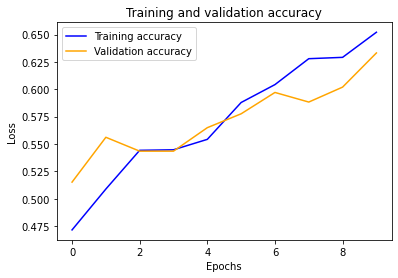

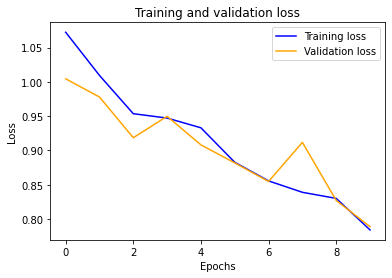

In [ ]:
#visualization of the model evaluation
#plot image will change with more epochs
accuracy = model_train.history['accuracy']
val_accuracy = model_train.history['val_accuracy']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))

#Visualize the accuracy
plt.plot(epochs, accuracy, 'b', c = 'blue', label = 'Training accuracy')
plt.plot(epochs, val_accuracy, 'b', c = 'orange', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()

#Visualize the loss
plt.plot(epochs, loss, 'b', c = 'blue', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', c = 'orange', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#save the model
#probably not important since ModelCheckpoint is initialized
#autoencoder.save_weights('autoencoder.h5')

# Model Evaluation on the Test Set

In [ ]:
test_eval = model.evaluate(X_test, label_test, verbose = 0)

In [ ]:
print('Test loss:', test_eval[0])
print('Test accuracy:', test_eval[1])

Test loss: 0.9196649193763733
Test accuracy: 0.5590304732322693


# Predict Labels

In [ ]:
predicted_classes = model.predict(X_test)

40/40 [==============================] - 3s 75ms/step


In [ ]:
predicted_classes = np.argmax(np.round(predicted_classes), axis = 1)

In [ ]:
predicted_classes.shape, label_test.shape

((1279,), (1279,))

Found 681 correct labels out of 1279 


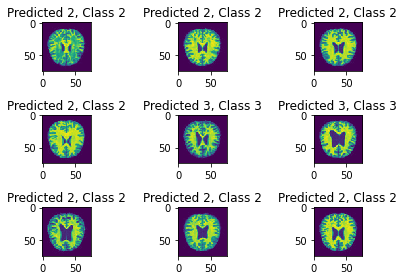

In [ ]:
correct = np.where(predicted_classes == label_test)[0]
print('Found %d correct labels' % len(correct) + ' out of %d ' % len(X_test))
for i, correct in enumerate(correct[:9]):
  plt.subplot(3,3, i+1)
  plt.imshow(X_test[correct].reshape(75, 75), interpolation = 'none')
  plt.title('Predicted {}, Class {}'.format(predicted_classes[correct], label_test[correct]))
  plt.tight_layout()

Found 598 incorrect labels  out of 1279 


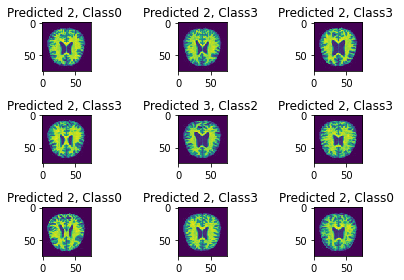

In [ ]:
incorrect = np.where(predicted_classes != label_test)[0]
print('Found %d incorrect labels ' % len(incorrect) + ' out of %d ' % len(X_test))
for i, incorrect in enumerate(incorrect[:9]):
  plt.subplot(3, 3, i+1)
  plt.imshow(X_test[incorrect].reshape(75, 75), interpolation = 'none')
  plt.title('Predicted {}, Class{} '.format(predicted_classes[incorrect], label_test[incorrect]))
  plt.tight_layout()

# Classification Report

In [ ]:
#create a classification report
target_names = ['Class {}'.format(i) for i in range(4)]
print(classification_report(label_test, predicted_classes, target_names = target_names))

              precision    recall  f1-score   support

     Class 0       0.29      0.47      0.36       179
     Class 1       0.00      0.00      0.00        12
     Class 2       0.63      0.84      0.72       640
     Class 3       0.46      0.14      0.21       448

    accuracy                           0.53      1279
   macro avg       0.34      0.36      0.32      1279
weighted avg       0.52      0.53      0.48      1279



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
